In [1]:
#!/usr/bin/python
from __future__ import absolute_import

import numpy as np
#from tensorflow import keras
import pickle
import argparse
import copy
import random
import time
import torch

from shapley.apps import Label, Poisoning
from shapley.loader import FashionMnist, MNIST, Flower
from shapley.measures import KNN_Shapley, KNN_LOO, G_Shapley, LOO, TMC_Shapley
from shapley.utils.plotter import LabelPlotter, PoisoningPlotter

%matplotlib inline

2023-05-13 06:27:51.742120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 06:27:52.774608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


# standalone experiments

A simple test for the two APIs
``KNN_Shapley._get_shapley_value_torch(self, X_train, y_train, X_test, y_test)`` (torch implementation)
and
``KNN_Shapley._get_shapley_value_np(self, X_train, y_train, X_test, y_test)`` (numpy implementation).

The torch implementation runs faster than the numpy version since the operations are paralleled. If running on cuda, the torch version will be even faster.

In [2]:
measure = KNN_Shapley(K=5)

In [3]:
X_train = torch.randn(1000, 28, 28)
X_test = torch.randn(100, 28, 28)

y_train = torch.LongTensor(1000).random_(0,10)
y_test = torch.LongTensor(100).random_(0,10)

In [4]:
start = time.time()
res1 = measure._get_shapley_value_torch(X_train, y_train, X_test, y_test).numpy()
print(res1.shape)
print(time.time() - start)

(1000,)
0.16169524192810059


In [5]:
X_train_cuda = X_train.cuda()
y_train_cuda = y_train.cuda()
X_test_cuda = X_test.cuda()
y_test_cuda = y_test.cuda()

start = time.time()
res3 = measure._get_shapley_value_torch(X_train_cuda, y_train_cuda, X_test_cuda, y_test_cuda)
print(time.time() - start)

1.0316576957702637


In [6]:
start = time.time()
res2 = measure._get_shapley_value_np(X_train, y_train, X_test, y_test)
print(time.time() - start)

1.7698473930358887


In [7]:
res1[:20]

array([-7.49059973e-06, -2.86437580e-06, -1.17090865e-04,  1.94109642e-04,
       -2.67431551e-05, -9.33601768e-05,  6.65605534e-04,  1.01060636e-04,
       -4.08736705e-05, -2.90916418e-04, -9.95771479e-05,  3.74313786e-05,
        8.71627781e-05,  5.75902232e-05,  2.92097306e-04, -1.66714381e-04,
       -4.78603079e-06, -2.02541240e-03, -2.09223763e-05, -5.98884653e-04],
      dtype=float32)

In [8]:
res2[:20]

array([-7.49064490e-06, -2.86432594e-06, -1.17091699e-04,  1.94109430e-04,
       -2.67431275e-05, -9.33598897e-05,  6.65604684e-04,  1.01060621e-04,
       -4.09970449e-05, -2.90917098e-04, -9.95772810e-05,  3.74307563e-05,
        8.71628219e-05,  5.75902729e-05,  2.92097208e-04, -1.66713723e-04,
       -4.78621809e-06, -2.02541228e-03, -2.09216526e-05, -5.98884610e-04])

# Noisy Label Detection

##### data loading

In [9]:
num = 1000
#loader = MNIST(num_train=num, one_hot=False, shuffle=True, by_label=True)
loader = FashionMnist(num_train=num,num_test = num)
# loader = Flower(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()

4422102/4422102 [==============================] - 0s 0us/step


###### measure

In [10]:
X_test_data.shape

(1000, 784)

In [11]:
X_data.shape

(1000, 784)

In [12]:
measure_KNN = KNN_Shapley(K=5)
measure_KNNLOO = KNN_LOO(K=5)
measure_gshap = G_Shapley()
measure_tmc = TMC_Shapley()
measure_LOO = LOO()

##### application

In [13]:
app = Label(X_data, y_data, X_test_data, y_test_data, model_family='NN')
# app = Label(X_data.reshape((X_data.shape[0],28,28,1)), y_data, X_test_data.reshape((X_test_data.shape[0],28,28,1)), y_test_data, model_family='ResNet')

##### run

In [15]:
start = time.time()
res_knn = app.run(measure_KNN)
print('KNN Shapley compute time: ',time.time()-start)

start = time.time()
res_knnloo = app.run(measure_KNNLOO)
print('KNN LOO compute time: ',time.time()-start)

start = time.time()
res_gshap = app.run(measure_gshap)
print('GShapley compute time: ',time.time()-start)

start = time.time()
res_tmc = app.run(measure_tmc)
print('TMC Shapley compute time: ',time.time()-start)

start = time.time()
res_loo = app.run(measure_LOO)
print('LOO compute time: ',time.time()-start)

ValueError: Type must be a sub-type of ndarray type

##### visualize

In [ ]:
LabelPlotter(app, ('KNN-Shapley',res_knn), ('KNN-LOO',res_knnloo), ('G-Shapley',res_gshap), ('TMC Shapley',res_tmc)).plot()

# Pattern-based Watermark Removal

##### data loading

In [7]:
num = 1000
loader = FashionMnist(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()

###### measure

In [8]:
measure_KNN = KNN_Shapley(K=5)
measure_KNNLOO = KNN_LOO(K=5)

##### application

In [9]:
app = Poisoning(X_data, y_data, X_test_data, y_test_data, model_family='NN')

##### run

In [10]:
res_knn = app.run(measure_KNN)
res_knnloo = app.run(measure_KNNLOO)

done!
result shown below:
[ 8.79628639e-04  1.55793842e-03  1.30519830e-03 -2.12431717e-06
  9.64479249e-04  1.04370420e-03  1.25988905e-03  1.44048475e-03
 -5.59342775e-05  1.75133921e-03  1.26808306e-03  5.66773231e-04
  1.47405479e-04  1.13472384e-03  8.50894844e-04  1.18168289e-04
 -9.60281068e-05 -3.00444417e-03  8.69257512e-04  5.24177716e-05
 -1.24801772e-04  5.52201017e-04  7.51384805e-04  7.26851145e-04
  8.97075488e-04  8.15197588e-04  7.04064283e-04  9.30564246e-04
  5.58762504e-04  7.10830232e-04 -1.30645670e-03  1.40518801e-03
  1.13915463e-03 -8.00112754e-04  7.66038233e-04  7.26814657e-04
 -1.52958342e-03  9.82845846e-04  6.81932682e-04  1.26714793e-04
  9.28260366e-04 -6.58806510e-04  7.68344909e-04  9.14238481e-04
  2.13691045e-04  1.23661917e-03  1.08512245e-03  5.74646453e-04
  1.39141788e-03  1.08022853e-03  9.98004241e-04  9.90456741e-04
 -1.88388830e-03 -1.72630550e-04  9.34984000e-04 -1.42940660e-03
  1.17746408e-03 -1.71778218e-04  7.53450439e-04  1.05578782e-03

##### visualize

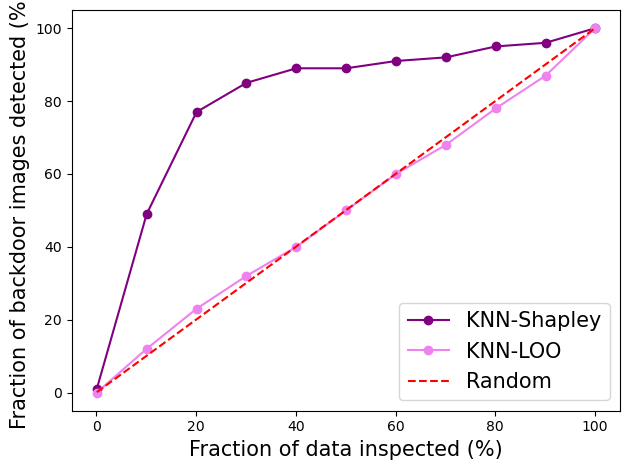

In [11]:
PoisoningPlotter(app, ('KNN-Shapley',res_knn), ('KNN-LOO',res_knnloo)).plot()

# Instance-based Watermark Removal

##### data loading

In [ ]:
# load MNIST

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # instance-based watermark removal

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Data Summarization

##### data loading

In [ ]:
# load UCI Adult dataset

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # data summarization

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Data Acquisition

##### data loading

In [ ]:
# load MNIST

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # data acquisition

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Domain Adapatation

##### data loading

In [ ]:
# load two datasets

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # domain adaptation

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED